# Steps to solve Gender classification problem

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Compiling the model</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>

## 1. Loading the dataset

File Descriptions
- train.zip: contains 2 csvs and 1 folder containing image data
- train.csv – [‘image_names’, ‘class’] contains the image name and correct class for 12196 train images
- image – contains images for both train and test sets
- test.csv: [‘image_names’] contains just the image names for 5227 images in the test set
- sample_submission.csv: [‘image_names’,’class’] contains the exact format for a valid submission

In [1]:
# import necessary libraries and functions
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense, InputLayer
from keras.models import Sequential

from sklearn.model_selection import train_test_split

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip /content/drive/My\ Drive/Dataset.zip

In [4]:
# reading the csv file
data = pd.read_csv('../data/gender/train.csv')

In [5]:
# create random number generator
seed = 42
rng = np.random.RandomState(seed)

In [6]:
# looking at first five rows of the data
data.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [7]:
# distribution of classes in the dataset
# Males are identified with a value of 1
data['class'].value_counts()

1    6174
0    6022
Name: class, dtype: int64

In [8]:
# load images and store it in numpy array

# empty list to store the images
# X = []
# # iterating over each image
# for img_name in data.image_names:
#     # loading the image using its name
#     img = plt.imread('../data/gender/images/' + img_name)
#     # saving each image in the list
#     X.append(img)

In [9]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:
    # loading the image using its name
    img = plt.imread('../data/gender/images/' + img_name)
    # normalizing the pixel values
    img = img/255
    # saving each image in the list
    X.append(img)
    
# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data['class'].values

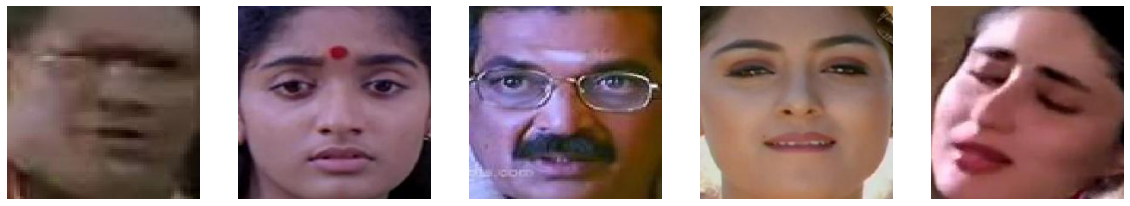

In [10]:
# visualizing images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X[i*400])
    ax[i].axis('off')

In [11]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)
print("y_train:", y_train.shape, "y_valid:", y_valid.shape)

X_train: (8537, 224, 224, 3) X_valid: (3659, 224, 224, 3)
y_train: (8537,) y_valid: (3659,)


## 2. Image Augmentation using Keras (ImageDataGenerator)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
image_augmentation = ImageDataGenerator(rotation_range=30, width_shift_range=40, height_shift_range=40, 
                              horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

In [14]:
image_augmentation.fit(X_train)

## 3. Model Building

In [15]:
# importing functions from keras to define the neural network architecture
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization, Flatten
from keras.models import Sequential
# importing adam optimizer from keras optimizer module 
from keras.optimizers import Adam

In [16]:
# defining the adam optimizer and setting the learning rate as 10^-5
adam = Adam(lr=1e-5)

In [17]:
# defining and compiling the model architecture
model=Sequential()
model.add(InputLayer(input_shape=(224,224,3))) #Note this is differnt than previous models, ImageDataGenerator requires keeping the RGB values
model.add(Flatten()) # Takes the input 3D layer to one dimensional
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [18]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               15052900  
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [19]:
# importing model checkpointing from keras callbacks
from keras.callbacks import ModelCheckpoint
# importing module for early stopping
from keras.callbacks import EarlyStopping

# setting up early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='min')

# defining model checkpointing

# defining the path to store the weights
filepath="best_weights.hdf5"

# defining the model checkpointing and metric to monitor
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# defining checkpointing variable
callbacks_list = [checkpoint, early_stopping]

In [20]:
# fits the model on batches with real-time data augmentation:
model_history = model.fit(image_augmentation.flow(X_train, y_train, batch_size=128), validation_data=(X_valid, y_valid), epochs=50, callbacks=callbacks_list) 

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.5671
Epoch 00001: val_accuracy improved from -inf to 0.59087, saving model to best_weights.hdf5
67/67 [==============================] - 127s 2s/step - loss: 0.9149 - accuracy: 0.5671 - val_loss: 0.6835 - val_accuracy: 0.5909
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.8772 - accuracy: 0.5746
Epoch 00002: val_accuracy improved from 0.59087 to 0.61356, saving model to best_weights.hdf5
67/67 [==============================] - 116s 2s/step - loss: 0.8772 - accuracy: 0.5746 - val_loss: 0.6761 - val_accuracy: 0.6136
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.5804
Epoch 00003: val_accuracy improved from 0.61356 to 0.64362, saving model to best_weights.hdf5
67/67 [==============================] - 113s 2s/step - loss: 0.8645 - accuracy: 0.5804 - val_loss: 0.6629 - val_accuracy: 0.6436
Epoch 4/50
67/67 [==============================]

In [21]:
print('Training Accuracy: ', accuracy_score(y_train, model.predict_classes(X_train)[:,0]))
print('\nValidation Accuracy: ', accuracy_score(y_valid, model.predict_classes(X_valid)[:,0]))

NameError: name 'accuracy_score' is not defined

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()